In [17]:
# ##google colab用にchainerのインストール
# !curl https://colab.chainer.org/install | sh -

In [18]:
# ##google driveのマウント
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
import numpy as np
import chainer

from chainer import cuda,Function,report,training,utils,Variable
from chainer import datasets,iterators,optimizers,serializers
from chainer import Link,Chain,ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import tuple_dataset
import matplotlib.pyplot as plt


%matplotlib inline

In [20]:
##GPU環境の設定を確認
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [21]:
##colab用にデータのpathを指定
##My Driveのカンマはpath指定の時にはいらない

#DATA_PATH = "/content/drive/My Drive/resarch"
#!ls /content/drive/'My Drive'/resarch/

DATA_PATH='./'

In [22]:
ls validation*.txt

validation_x_test_corr_high_add_salt_and_papper.txt
validation_x_test_corr_high_add_salt_and_papper_half.txt
validation_x_test_corr_high_add_salt_and_papper_side_to_side.txt
validation_x_test_corr_high_test_without_add_no_noise.txt
validation_x_test_corr_high_test_without_add_salt_and_papper.txt
validation_x_test_corr_high_test_without_add_salt_and_papper_side_to_side.txt
validation_x_test_corr_high_test_without_add_some_noise.txt
validation_x_test_corr_high_test_without_add_some_noise_samesample.txt
validation_x_test_corr_high_test_without_add_some_noise_samesample2.txt
validation_x_test_corr_high_test_without_add_some_noise_samesample_only6.txt
validation_x_train_corr_high_add_salt_and_papper.txt
validation_x_train_corr_high_add_salt_and_papper_half.txt
validation_x_train_corr_high_add_salt_and_papper_side_to_side.txt
validation_x_train_corr_high_test_without_add_no_noise.txt
validation_x_train_corr_high_test_without_add_salt_and_papper.txt
validation_x_train_corr_high_test_without_a

In [23]:
##データの読み込み
import pickle

##train
f=open(DATA_PATH+"/validation_x_train_corr_high_test_without_add_some_noise_samesample_only6.txt","rb")
x_train=pickle.load(f)

f=open(DATA_PATH+"/validation_y_train_corr_high_test_without_add_some_noise_samesample_only6.txt","rb")
y_train=pickle.load(f)

##test
f=open(DATA_PATH+"/validation_x_test_corr_high_test_without_add_some_noise_samesample_only6.txt","rb")
x_test=pickle.load(f)

f=open(DATA_PATH+"/validation_y_test_corr_high_test_without_add_some_noise_samesample_only6.txt","rb")
y_test=pickle.load(f)

In [24]:
##データをcupyに変換
import cupy as cp
##train
x_train=cp.asarray(x_train,dtype=cp.float32)
y_train=cp.asarray(y_train,dtype=cp.int32)

##test
x_test=cp.asarray(x_test,dtype=cp.float32)
y_test=cp.asarray(y_test,dtype=cp.int32)

In [ ]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.5
0.13953314937728392


In [ ]:
x_train.shape

(500000, 30, 11)

In [ ]:
##画像を4次元に変換
x_train=x_train.reshape(len(x_train), 1, 30, 11)
x_test=x_test.reshape(len(x_test), 1, 30, 11)

In [ ]:

##tuple data set化
# data= tuple_dataset.TupleDataset(x,y)
# split_at=int(len(x)*0.95)
# train,test=chainer.datasets.split_dataset(data ,split_at)

##train
train = tuple_dataset.TupleDataset(x_train,y_train)
##test
test = tuple_dataset.TupleDataset(x_test,y_test)

入力画像は30x11<br>
畳み込みでは、まず一週間の行動の特徴抽出という意味で7x1でストライド1で行う<br>
次に全特徴量、つまり1x11でストライドさせる<br>
(そして、maxpoolingでプーリングする)<br>
全結合からの中間層挟んで、最後に出力<br>

改善案<br>
精度良ければ、その他の手法と比較する<br>
精度悪ければ残差学習を用いる



In [ ]:
#ネットワーク定義

out_chanel1=64
out_chanel2=32
out_chanel3=64
k_size=3
pad_size=1
initializer = chainer.initializers.HeNormal()
class Purchase(Chain):
    def __init__(self):
        super(Purchase , self).__init__(
            ##k_size:3
            conv0=L.Convolution2D(1,out_chanel1,ksize=5,pad=2,initialW=initializer),
            ##
            conv1=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv2=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv3=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv4=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv5=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv6=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv7=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv8=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv9=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv10=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv11=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv12=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv13=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv14=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv15=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv16=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv17=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv18=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv19=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv20=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv21=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv22=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv23=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv24=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv25=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv26=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            conv27=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
            ##
            conv28=L.Convolution2D(out_chanel1,out_chanel1,ksize=k_size,pad=pad_size,initialW=initializer),
#             conv29=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv30=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv31=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv32=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv33=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv34=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv35=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv36=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv37=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv38=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv39=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv40=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv41=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv42=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv43=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv44=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv45=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv46=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv47=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv48=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             ##
#             conv49=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
#             conv50=L.Convolution2D(out_chanel1,out_chanel1,ksize=5,pad=2),
            
            
            bn0=L.BatchNormalization(out_chanel1),
            bn1=L.BatchNormalization(out_chanel1),
            bn2=L.BatchNormalization(out_chanel1),
            bn3=L.BatchNormalization(out_chanel1),
            bn4=L.BatchNormalization(out_chanel1),
            bn5=L.BatchNormalization(out_chanel1),
            bn6=L.BatchNormalization(out_chanel1),
            bn7=L.BatchNormalization(out_chanel1),
            bn8=L.BatchNormalization(out_chanel1),
            bn9=L.BatchNormalization(out_chanel1),
            bn10=L.BatchNormalization(out_chanel1),
            bn11=L.BatchNormalization(out_chanel1),
            bn12=L.BatchNormalization(out_chanel1),
            bn13=L.BatchNormalization(out_chanel1),
            bn14=L.BatchNormalization(out_chanel1),
            bn15=L.BatchNormalization(out_chanel1),
            bn16=L.BatchNormalization(out_chanel1),
            bn17=L.BatchNormalization(out_chanel1),
            bn18=L.BatchNormalization(out_chanel1),
            bn19=L.BatchNormalization(out_chanel1),
            bn20=L.BatchNormalization(out_chanel1),
            bn21=L.BatchNormalization(out_chanel1),
            bn22=L.BatchNormalization(out_chanel1),
            bn23=L.BatchNormalization(out_chanel1),
            bn24=L.BatchNormalization(out_chanel1),
            bn25=L.BatchNormalization(out_chanel1),
            bn26=L.BatchNormalization(out_chanel1),
            bn27=L.BatchNormalization(out_chanel1),
            bn28=L.BatchNormalization(out_chanel1),
#             bn29=L.BatchNormalization(out_chanel1),
#             bn30=L.BatchNormalization(out_chanel1),
#             bn31=L.BatchNormalization(out_chanel1),
#             bn32=L.BatchNormalization(out_chanel1),
#             bn33=L.BatchNormalization(out_chanel1),
#             bn34=L.BatchNormalization(out_chanel1),
#             bn35=L.BatchNormalization(out_chanel1),
#             bn36=L.BatchNormalization(out_chanel1),
#             bn37=L.BatchNormalization(out_chanel1),
#             bn38=L.BatchNormalization(out_chanel1),
#             bn39=L.BatchNormalization(out_chanel1),
#             bn40=L.BatchNormalization(out_chanel1),
#             bn41=L.BatchNormalization(out_chanel1),
#             bn42=L.BatchNormalization(out_chanel1),
#             bn43=L.BatchNormalization(out_chanel1),
#             bn44=L.BatchNormalization(out_chanel1),
#             bn45=L.BatchNormalization(out_chanel1),
#             bn46=L.BatchNormalization(out_chanel1),
#             bn47=L.BatchNormalization(out_chanel1),
#             bn48=L.BatchNormalization(out_chanel1),
#             bn49=L.BatchNormalization(out_chanel1),
#             bn50=L.BatchNormalization(out_chanel1),
            l1=L.Linear(None,2),
           
        
        )
        self.act=F.rrelu
#         self.conv_num = conv_num
#         if activate == 'relu':
#             self.act = F.relu
#         elif activate == 'tanh':
#             self.act = F.tanh
#         elif activate == 'leakly_relu':
#             self.act = F.leaky_relu
        
    def __call__(self,x):
            h0=self.act(self.bn0(self.conv0(x)))
            h1=self.act(self.bn1(self.conv1(h0)))
            h2=self.act(self.bn2(self.conv2(h1)))
            h3=self.act(self.bn3(self.conv3(h2))+h1)
            h4=self.act(self.bn4(self.conv4(h3)))
            h5=self.act(self.bn5(self.conv5(h4))+h3)
            h6=self.act(self.bn6(self.conv6(h5)))
            h7=self.act(self.bn7(self.conv7(h6))+h5)
            h8=self.act(self.bn8(self.conv8(h7)))
            h9=self.act(self.bn9(self.conv9(h8))+h7)
            h10=self.act(self.bn10(self.conv10(h9)))
            h11=self.act(self.bn11(self.conv11(h10))+h9)
            h12=self.act(self.bn12(self.conv12(h11)))
            h13=self.act(self.bn13(self.conv13(h12))+h11)
            h14=self.act(self.bn14(self.conv14(h13)))
            h15=self.act(self.bn15(self.conv15(h14))+h13)
            h16=self.act(self.bn16(self.conv16(h15)))
            h17=self.act(self.bn17(self.conv17(h16))+h15)
            h18=self.act(self.bn18(self.conv18(h17)))
            h19=self.act(self.bn19(self.conv19(h18))+h17)
            h20=self.act(self.bn20(self.conv20(h19)))
            h21=self.act(self.bn21(self.conv21(h20))+h19)
            h22=self.act(self.bn22(self.conv22(h21)))
            h23=self.act(self.bn23(self.conv23(h22))+h21)
            h24=self.act(self.bn24(self.conv24(h23)))
            h25=self.act(self.bn25(self.conv25(h24))+h23)
            h26=self.act(self.bn26(self.conv26(h25)))
            h27=self.act(self.bn27(self.conv27(h26))+h25)
            h28=self.act(self.bn28(self.conv28(h27)))
#             h29=self.act(self.bn29(self.conv29(h28))+h27)
#             h30=self.act(F.dropout(self.bn30(self.conv30(h29))))
#             h31=self.act(self.bn31(self.conv31(h30))+h29)
#             h32=self.act(F.dropout(self.bn32(self.conv32(h31))))
#             h33=self.act(self.bn33(self.conv33(h32))+h31)
#             h34=self.act(F.dropout(self.bn34(self.conv34(h33))))
#             h35=self.act(self.bn35(self.conv35(h34))+h33)
#             h36=self.act(F.dropout(self.bn36(self.conv36(h35))))
#             h37=self.act(self.bn37(self.conv37(h36))+h35)
#             h38=self.act(F.dropout(self.bn38(self.conv38(h37))))
#             h39=self.act(self.bn39(self.conv39(h38))+h37)
#             h40=self.act(F.dropout(self.bn40(self.conv40(h39))))
#             h41=self.act(self.bn41(self.conv41(h40))+h39)
#             h42=self.act(F.dropout(self.bn42(self.conv42(h41))))
#             h43=self.act(self.bn43(self.conv43(h42))+h41)
#             h44=self.act(F.dropout(self.bn44(self.conv44(h43))))
#             h45=self.act(self.bn45(self.conv45(h44))+h43)
#             h46=self.act(F.dropout(self.bn46(self.conv46(h45))))
#             h47=self.act(self.bn47(self.conv47(h46))+h45)
#             h48=self.act(F.dropout(self.bn48(self.conv48(h47))))
#             h49=self.act(self.bn49(self.conv49(h48))+h47)
#             h50=self.act(F.dropout(self.bn50(self.conv50(h49))))
            
            return self.l1(h28)
 

In [ ]:
##学習方法の定義

model=Purchase()
model = L.Classifier(model)
'''学習再開するときは次のコードも実行する'''
#serializers.load_hdf5("purchase_CNN_64.hdf5",model)


##GPUの設定

use_device=0

if use_device==0:
    cuda.get_device(0).use()
    model.to_gpu()

    
##作成したデータの番号をランダムに選択


##繰り返し条件
##データサンプルの大きさにバッチを合わせる
batch_size=64
train_iter=iterators.SerialIterator(train,batch_size,shuffle=True)
test_iter=iterators.SerialIterator(test,batch_size,repeat=False,shuffle=False)

##誤差逆伝搬の定義
optimizer=optimizers.Adam()
optimizer.setup(model)

##trainerの作成
updater=training.StandardUpdater(train_iter,optimizer,device=use_device)
trainer=training.Trainer(updater,(20,'epoch'),out="result/residual/Adam/")

##trainerをtestに適用
trainer.extend(extensions.Evaluator(test_iter,model,device=use_device))

##ログの出力
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
 
# 損失関数の値をグラフにする機能
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
 
# 正答率をグラフにする機能
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
 
#trainer.extend(extensions.dump_graph('main/loss'))

##学習をrun
trainer.run()

##学習結果を保存する
#chainer.serializers.save_hdf5('purchase_CNN_64.hdf5',model)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.709758    0.558522       0.689946              0.572236                  504.908       
2           0.676404    0.575201       0.641975              0.643047                  1010.57       
3           0.674629    0.579147       0.699418              0.52796                   1517.72       
4           0.672185    0.583083       0.723382              0.506038                  2035.98       
5           0.668908    0.588956       0.668497              0.621544                  2563.56       
6           0.663788    0.596558       0.623                 0.67824                   3096.28       
7           0.656024    0.607071       0.635209              0.681732                  3624.4        
8           0.644682    0.61969        0.736297              0.557495                  4142.79       
9           0.630842    0.634171       0.710308              0.629965               

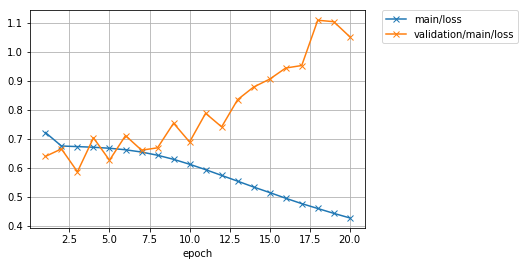

In [15]:
from IPython.display import Image
Image(filename='./result/residual/Adam/loss.png')

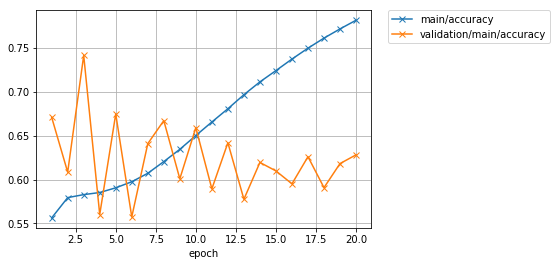

In [16]:
from IPython.display import Image
Image(filename='./result/residual/Adam/accuracy.png')

## メモ


In [18]:
sum(y_test)/len(y_test)

array(0.33300643)